In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [ ]:
# --- Download Data Saham ---
ticker = 'TLKM.JK'
data = yf.download(ticker, start='2023-01-01', end='2025-08-01')
if data.empty:
    raise ValueError("Data kosong, mungkin terjadi error saat download atau ticker tidak valid.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# --- Fitur yang digunakan: 'Close' dan 'Volume' ---
df = data[['Close', 'Volume']].copy()
df.dropna(inplace=True)

In [ ]:
# --- Pisahkan data training dan testing berdasarkan tanggal ---
train_df = df.loc[:'2024-12-31']
test_df = df.loc['2025-01-01':]

In [ ]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (476, 2)
Testing data shape: (92, 2)


In [ ]:
# --- Normalisasi ---
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

# --- Gabungkan 60 hari terakhir training dengan testing ---
last_60_train = scaled_train[-60:]
combined_scaled = np.concatenate((last_60_train, scaled_test), axis=0)

In [ ]:
# --- Fungsi Membuat Dataset Time-Series ---
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(combined_scaled, time_step)

In [ ]:
# --- Model LSTM ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1676
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0248
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0157
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0147
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0105
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0114
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0090
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0103
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0102
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0082
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0094
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0080
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0077
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0070
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0082
Epoch 16/50
13/

In [ ]:
# --- Prediksi ---
test_predict = model.predict(X_test)
test_predicted_prices = scaler.inverse_transform(np.hstack((test_predict, np.zeros((test_predict.shape[0], 1)))))[:, 0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


In [ ]:
# --- Real Prices dan Dates untuk Jan - Mei ---
real_test_prices = test_df['Close'].values[time_step:]
real_test_dates = test_df.index[time_step:]
test_predicted_prices = test_predicted_prices[-len(real_test_prices):]

In [ ]:
# --- Hitung RMSE Jan - Mei 2025 ---
mse = mean_squared_error(real_test_prices, test_predicted_prices)
rmse = np.sqrt(mse)
print(f"MSE (Jan–Mei 2025): {mse:.4f}")
print(f"RMSE (Jan–Mei 2025): {rmse:.4f}")

MSE (Jan–Mei 2025): 7062.1688
RMSE (Jan–Mei 2025): 84.0367


In [ ]:
# Ambil 60 langkah terakhir dari data test untuk prediksi berantai
last_sequence = combined_scaled[-60:]
predicted_future = []

In [ ]:
# Prediksi 1 langkah ke depan terus-menerus selama 23 hari kerja (29 Mei - 1 Juli 2025)
for _ in range(23):
    input_seq = last_sequence[-60:].reshape(1, 60, 2)
    pred = model.predict(input_seq, verbose=0)[0][0]
    predicted_future.append(pred)

    # Tambah prediksi sebagai data baru untuk input berikutnya
    dummy_volume = last_sequence[-1, 1]  # gunakan volume terakhir sebagai dummy
    last_sequence = np.vstack([last_sequence, [pred, dummy_volume]])

In [ ]:
# Inverse transform prediksi masa depan
future_scaled = np.array(predicted_future).reshape(-1, 1)
future_combined = np.hstack((future_scaled, np.zeros_like(future_scaled)))
predicted_future_prices = scaler.inverse_transform(future_combined)[:, 0]

# --- Siapkan tanggal prediksi (29 Mei – 1 Juli 2025) ---
future_dates = pd.bdate_range(start=real_test_dates[-1] + pd.Timedelta(days=1), periods=23)

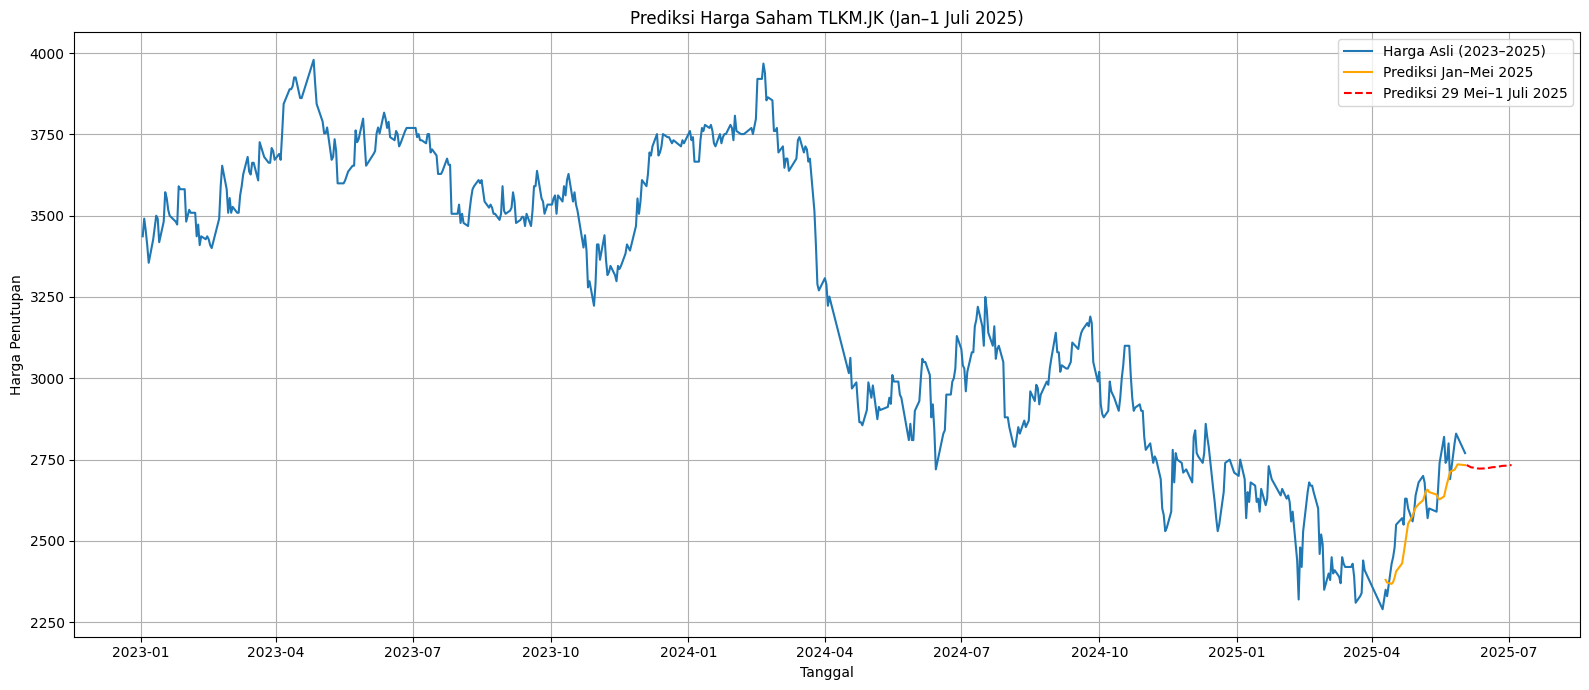

In [ ]:
# --- Gabungkan semua ke visualisasi ---
plt.figure(figsize=(16, 7))
plt.plot(df['Close'], label='Harga Asli (2023–2025)')
plt.plot(real_test_dates, test_predicted_prices, label='Prediksi Jan–Mei 2025', color='orange')
plt.plot(future_dates, predicted_future_prices, label='Prediksi 29 Mei–1 Juli 2025', color='red', linestyle='--')
plt.title('Prediksi Harga Saham TLKM.JK (Jan–1 Juli 2025)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()